In [1]:
import pickle
import torch
import copy

import numpy as np
import pandas as pd

from skimage import io
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from torchvision import transforms
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.models as models


from matplotlib import colors, pyplot as plt
%matplotlib inline

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
torch.cuda.is_available()

CUDA is available!  Training on GPU ...


True

In [2]:
SEED = 69

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")
EPOCHS=24
BATCH_SIZE=64

In [3]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        transform_list = []
        transform_list.append(transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)))
        if self.mode != 'test':            
            transform_list.append(transforms.RandomHorizontalFlip())
            transform_list.append(transforms.RandomRotation(15))
        transform_list.append(transforms.ToTensor())
        transform_list.append(transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))

        transform = transforms.Compose(transform_list)
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [4]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [5]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]

In [6]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

In [7]:
dct_path_train = create_dct_path_labels(train_val_files, train_val_labels)

for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])
        
train_val_files = []
for person in dct_path_train:
    train_val_files.extend(dct_path_train[person])

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

val_dataset = SimpsonsDataset(val_files, mode='val')

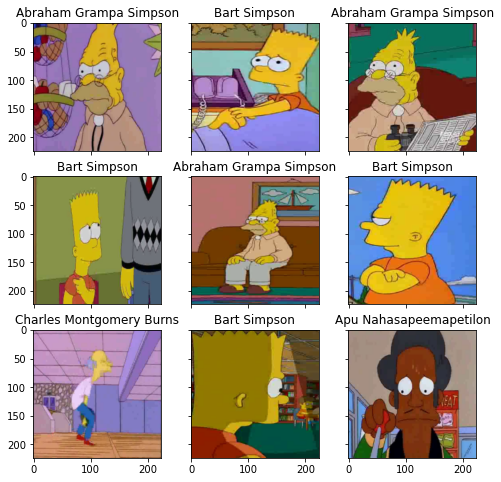

In [8]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [9]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [10]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [11]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())
        criterion = nn.CrossEntropyLoss()
        #scheduler = torch.optim.lr_scheduler.StepLR(opt, 2, gamma=0.5)
        
        best_acc = 0.0
        
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            #scheduler.step()
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            if val_acc > best_acc:
                best_model_wghts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wghts, './model/premade.mdl')
                best_acc = val_acc
    print(best_acc)        
    return history

In [12]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [13]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')
n_classes = len(np.unique(train_val_labels))

In [14]:
model = models.resnet34(pretrained=False)
    
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=n_classes)
model = model.to('cuda')

In [15]:
history = train(train_dataset, val_dataset, model=model, epochs=EPOCHS, batch_size=BATCH_SIZE)

epoch:   0%|                                                                                    | 0/40 [00:00<?, ?it/s]

loss 2.1154040449972094


epoch:   2%|█▊                                                                       | 1/40 [02:19<1:30:21, 139.02s/it]


Epoch 001 train_loss: 2.1154     val_loss 2.1555 train_acc 0.4334 val_acc 0.4529
loss 3.211158971222951


epoch:   5%|███▋                                                                     | 2/40 [04:32<1:27:01, 137.41s/it]


Epoch 002 train_loss: 3.2112     val_loss 2.9628 train_acc 0.1164 val_acc 0.1698
loss 2.6680947515247726


epoch:   8%|█████▍                                                                   | 3/40 [06:48<1:24:27, 136.95s/it]


Epoch 003 train_loss: 2.6681     val_loss 2.3235 train_acc 0.2682 val_acc 0.3489
loss 2.0702815066086893


epoch:  10%|███████▎                                                                 | 4/40 [09:05<1:22:08, 136.91s/it]


Epoch 004 train_loss: 2.0703     val_loss 1.7426 train_acc 0.4281 val_acc 0.5227
loss 1.5436570487369534


epoch:  12%|█████████▏                                                               | 5/40 [11:17<1:19:05, 135.59s/it]


Epoch 005 train_loss: 1.5437     val_loss 1.3300 train_acc 0.5677 val_acc 0.6232
loss 1.1679187750002977


epoch:  15%|██████████▉                                                              | 6/40 [13:28<1:15:55, 133.99s/it]


Epoch 006 train_loss: 1.1679     val_loss 1.1323 train_acc 0.6705 val_acc 0.6908
loss 0.8914081941898588


epoch:  18%|████████████▊                                                            | 7/40 [15:39<1:13:15, 133.18s/it]


Epoch 007 train_loss: 0.8914     val_loss 0.9898 train_acc 0.7463 val_acc 0.7292
loss 0.6897875801514025


epoch:  20%|██████████████▌                                                          | 8/40 [17:52<1:10:58, 133.07s/it]


Epoch 008 train_loss: 0.6898     val_loss 0.8765 train_acc 0.7986 val_acc 0.7601
loss 0.543108103117709


epoch:  22%|████████████████▍                                                        | 9/40 [20:07<1:09:07, 133.79s/it]


Epoch 009 train_loss: 0.5431     val_loss 0.7623 train_acc 0.8425 val_acc 0.8046
loss 0.41862570827159074


epoch:  25%|██████████████████                                                      | 10/40 [22:17<1:06:18, 132.60s/it]


Epoch 010 train_loss: 0.4186     val_loss 0.7558 train_acc 0.8741 val_acc 0.8151
loss 0.30258223053443517


epoch:  28%|███████████████████▊                                                    | 11/40 [24:29<1:04:01, 132.47s/it]


Epoch 011 train_loss: 0.3026     val_loss 1.0046 train_acc 0.9123 val_acc 0.7926
loss 0.24477855463126721


epoch:  30%|█████████████████████▌                                                  | 12/40 [26:40<1:01:35, 131.98s/it]


Epoch 012 train_loss: 0.2448     val_loss 0.7977 train_acc 0.9246 val_acc 0.8207
loss 0.1874395291987912


epoch:  32%|████████████████████████                                                  | 13/40 [28:51<59:18, 131.80s/it]


Epoch 013 train_loss: 0.1874     val_loss 0.6743 train_acc 0.9442 val_acc 0.8383
loss 0.14554720730805884


epoch:  35%|█████████████████████████▉                                                | 14/40 [31:02<56:57, 131.46s/it]


Epoch 014 train_loss: 0.1455     val_loss 0.8863 train_acc 0.9556 val_acc 0.8469
loss 0.13296769328444896


epoch:  38%|███████████████████████████▊                                              | 15/40 [33:13<54:43, 131.34s/it]


Epoch 015 train_loss: 0.1330     val_loss 0.8245 train_acc 0.9597 val_acc 0.8436
loss 0.10161663778455308


epoch:  40%|█████████████████████████████▌                                            | 16/40 [35:24<52:25, 131.05s/it]


Epoch 016 train_loss: 0.1016     val_loss 0.9264 train_acc 0.9684 val_acc 0.8478
loss 0.08581633204665175


epoch:  42%|███████████████████████████████▍                                          | 17/40 [37:37<50:30, 131.76s/it]


Epoch 017 train_loss: 0.0858     val_loss 0.9085 train_acc 0.9745 val_acc 0.8472
loss 0.07216303679925293


epoch:  45%|█████████████████████████████████▎                                        | 18/40 [39:50<48:26, 132.11s/it]


Epoch 018 train_loss: 0.0722     val_loss 0.9368 train_acc 0.9766 val_acc 0.8366
loss 0.08481218301399775


epoch:  48%|███████████████████████████████████▏                                      | 19/40 [42:02<46:13, 132.05s/it]


Epoch 019 train_loss: 0.0848     val_loss 0.8260 train_acc 0.9752 val_acc 0.8490
loss 0.06745476555981325


epoch:  50%|█████████████████████████████████████                                     | 20/40 [44:16<44:15, 132.78s/it]


Epoch 020 train_loss: 0.0675     val_loss 0.8494 train_acc 0.9801 val_acc 0.8511
loss 0.05396131912965192


epoch:  52%|██████████████████████████████████████▊                                   | 21/40 [46:32<42:17, 133.53s/it]


Epoch 021 train_loss: 0.0540     val_loss 0.9955 train_acc 0.9836 val_acc 0.8507
loss 0.05356147582011545


epoch:  55%|████████████████████████████████████████▋                                 | 22/40 [48:49<40:22, 134.59s/it]


Epoch 022 train_loss: 0.0536     val_loss 1.0625 train_acc 0.9841 val_acc 0.8372
loss 0.06519143618393645


epoch:  57%|██████████████████████████████████████████▌                               | 23/40 [51:00<37:51, 133.64s/it]


Epoch 023 train_loss: 0.0652     val_loss 1.0544 train_acc 0.9798 val_acc 0.8385
loss 0.034078270961262994


epoch:  60%|████████████████████████████████████████████▍                             | 24/40 [53:12<35:32, 133.26s/it]


Epoch 024 train_loss: 0.0341     val_loss 1.0712 train_acc 0.9901 val_acc 0.8368
loss 0.051851235313878315


epoch:  62%|██████████████████████████████████████████████▎                           | 25/40 [55:23<33:06, 132.41s/it]


Epoch 025 train_loss: 0.0519     val_loss 1.0839 train_acc 0.9837 val_acc 0.8637
loss 0.05822995202459833


epoch:  65%|████████████████████████████████████████████████                          | 26/40 [57:34<30:48, 132.02s/it]


Epoch 026 train_loss: 0.0582     val_loss 0.9444 train_acc 0.9828 val_acc 0.8553
loss 0.050650409412432144


epoch:  68%|█████████████████████████████████████████████████▉                        | 27/40 [59:47<28:38, 132.22s/it]


Epoch 027 train_loss: 0.0507     val_loss 0.8042 train_acc 0.9849 val_acc 0.8600
loss 0.031254022360413115


epoch:  70%|██████████████████████████████████████████████████▍                     | 28/40 [1:02:00<26:30, 132.56s/it]


Epoch 028 train_loss: 0.0313     val_loss 0.9064 train_acc 0.9909 val_acc 0.8702
loss 0.022720286774696136


epoch:  72%|████████████████████████████████████████████████████▏                   | 29/40 [1:04:11<24:14, 132.21s/it]


Epoch 029 train_loss: 0.0227     val_loss 1.3465 train_acc 0.9941 val_acc 0.8302
loss 0.06056349496906065


epoch:  75%|██████████████████████████████████████████████████████                  | 30/40 [1:06:20<21:51, 131.15s/it]


Epoch 030 train_loss: 0.0606     val_loss 0.9338 train_acc 0.9836 val_acc 0.8527
loss 0.0396517426170411


epoch:  78%|███████████████████████████████████████████████████████▊                | 31/40 [1:08:29<19:33, 130.44s/it]


Epoch 031 train_loss: 0.0397     val_loss 0.9152 train_acc 0.9883 val_acc 0.8123
loss 0.04779898204292933


epoch:  80%|█████████████████████████████████████████████████████████▌              | 32/40 [1:10:42<17:29, 131.24s/it]


Epoch 032 train_loss: 0.0478     val_loss 0.8559 train_acc 0.9860 val_acc 0.8487
loss 0.03792254504314509


epoch:  82%|███████████████████████████████████████████████████████████▍            | 33/40 [1:12:57<15:25, 132.28s/it]


Epoch 033 train_loss: 0.0379     val_loss 0.8540 train_acc 0.9889 val_acc 0.8609
loss 0.025648153957505457


epoch:  85%|█████████████████████████████████████████████████████████████▏          | 34/40 [1:15:11<13:18, 133.03s/it]


Epoch 034 train_loss: 0.0256     val_loss 0.9563 train_acc 0.9930 val_acc 0.8697
loss 0.024509427636787193


epoch:  88%|███████████████████████████████████████████████████████████████         | 35/40 [1:17:28<11:10, 134.07s/it]


Epoch 035 train_loss: 0.0245     val_loss 0.9449 train_acc 0.9936 val_acc 0.8587
loss 0.03594109967669817


epoch:  90%|████████████████████████████████████████████████████████████████▊       | 36/40 [1:19:46<09:01, 135.26s/it]


Epoch 036 train_loss: 0.0359     val_loss 0.8699 train_acc 0.9890 val_acc 0.8547
loss 0.029032984289730807


epoch:  92%|██████████████████████████████████████████████████████████████████▌     | 37/40 [1:22:03<06:47, 135.84s/it]


Epoch 037 train_loss: 0.0290     val_loss 0.9595 train_acc 0.9918 val_acc 0.8662
loss 0.03323079720528146


epoch:  95%|████████████████████████████████████████████████████████████████████▍   | 38/40 [1:24:39<04:43, 141.83s/it]


Epoch 038 train_loss: 0.0332     val_loss 1.0233 train_acc 0.9906 val_acc 0.8516
loss 0.028130389129538164


epoch:  98%|██████████████████████████████████████████████████████████████████████▏ | 39/40 [1:27:25<02:29, 149.05s/it]


Epoch 039 train_loss: 0.0281     val_loss 0.7840 train_acc 0.9918 val_acc 0.8516
loss 0.03546022304920681


epoch: 100%|████████████████████████████████████████████████████████████████████████| 40/40 [1:29:38<00:00, 134.46s/it]


Epoch 040 train_loss: 0.0355     val_loss 0.9646 train_acc 0.9884 val_acc 0.8494
tensor(0.8702, device='cuda:0', dtype=torch.float64)


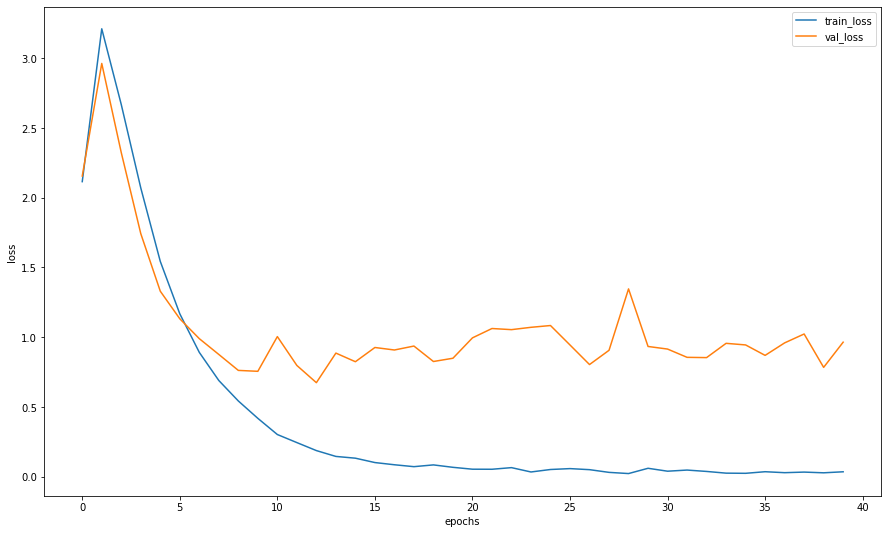

In [16]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [17]:
model.load_state_dict(torch.load('./model/premade.mdl'))

<All keys matched successfully>

In [18]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [19]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))
idxs = list(map(int, np.random.uniform(0,1000, 20)))

imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims = predict(model, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]

f1_score(actual_labels, y_pred, average='weighted')

0.9741379310344829

In [20]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv('./out/my_submit_premade_aug_kf.csv', index=False)
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
